# A notebook in R for modelling species distributions and sample effort using 
## CAR models

The conditional autologistic model (Besage, et. al 1991) has the following specification (Lee, 2013).


In [1]:
library(CARBayes)
library(dplyr)
library(purrr)

Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#file = '/outputs/presence_only_models/predictors/dataset100x100-puebla-p9/0-pred.csv'
#PDF = read.csv(file)
## REad adjancency matrix
mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
library(reticulate)
np <- import("numpy")
M <- np$load(mat_filename)
TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same
TDF = TDF[order(TDF$cell_ids),]

TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,MaxTemp_m,MeanTemp_m,MinTemp_m,Population_m,Precipitation_m,SolarRadiation_m,VaporPres_m,WindSp_m),as.numeric)
#TDF = sapply(TDF,as.numeric)
#TDF = data.frame(TDF)
#TDF = mutate_at(TDF, vars(wwf_mhtnam,name,tipos),as.factor)
names(TDF) = lapply(names(TDF),function(x) gsub("_","",x))
names(TDF) = lapply(names(TDF),function(x) gsub("\\.","",x))
                    
### Mini script para borrar entrada con 0 neighbours
D = apply(M,MARGIN = 1,sum)
idx = match(0,D)
## Please check that the order is ok
# Checked, 
cell_with_no_neighbour = TDF$cellids[idx]
## look in the gis
## Erase idx for M and for TDF (Or maybe only for M)
M_bis = M[-c(idx),-c(idx)]

formula_sample=LUCA~Disttoroadm+Populationm #+factor(tipos)
formula_presence=Pinophyta~Elevationm+MeanTempm
n <- nrow(TDF)
trials <- rep(1,n)

                    

In [3]:
## Function for pseudopresence according to the meeting discussed in February 22, 2019
## Include NA's as the sites were neither the Sample effort and the 

## The model
The Conditional-autologistic model is a hierarchical model:

$$ P_i = logit^{-1}(\beta^t X + \phi_i )$$

When conditioned to $\phi$ (i.e the MRGF), $[ Y | \Phi] \sim Bernoulli(P_i)$

Now, $\phi$ is a GMRF that uses the adjacency matrix of the spatial structure to model the spatial autocorrelation.


## The implementation
The model can be implemented in R with the CARBayes package to infer the posterior distribution of $[ \phi,\beta | Y,X]$
However, $Y$ is presence-only data. Assuming a bernoulli distribution associated, implies that a further reasoning for modelling absences is necessary.

## Design for sampling absences (i.e Pseudo absence method)
Species occurrences can be seen as (nodes) leaves in the Taxonomic Tree of Life. As such, each species has a parent node. In general, with the exception of the Root node, each node has a relation of parenthood to another node.

Modeling absences for species (node) $y$ should also include another node of reference. For example, one may be interested in modeling Abies. The absences of Abies are going to be modelled as the places where at least one sample (of any other node) exists. The rest of the places (i.e. places that haven't been sampled are going to be considered null. We will explore the treatment of the Null values later.


![alt text](observation_pseudoabsences.png "Presences")


In [4]:
# Let's build the pseudoabsences
pseudo_absence_species <- function(S,relative_sample,background) {
    # All arguments are binary
    # S = presence of specie
    # relative_sample = the presence of the relative group
    # backgroudn = The entire background sample
    if ( ! background ) {
        return(NA)
    }
    else if ( S ) {
        return(1)
    }
    ## insert here in case of something different for 0 (i.e. relative=0 and back =1)
    else {
        return(0)
    }
        
}

# Let's build the pseudoabsences
pseudo_absence_sample <- function(relative_sample,background) {
    # All arguments are binary
    # S = presence of specie
    # relative_sample = the presence of the relative group
    # backgroudn = The entire background sample
    if ( ! background ) {
        return(NA)
    }
    else if ( relative_sample ) {
        return(1)
    }
    ## insert here in case of something different for 0 (i.e. relative=0 and back =1)
    else {
        return(0)
    }
        
}


In [5]:
library('biospytial.rwrapper')

In [6]:
#obs = data.frame(TDF) %>% 
#        rowwise() %>% 
#            mutate(ps_abs_samp=pseudo_absence_sample(Pinophyta,LUCA),
#                   ps_abs_species = pseudo_absence_species(Abies,Pinophyta,LUCA))

obs = data.frame(TDF) %>% 
        rowwise() %>% 
            mutate(ps_abs_samp=pseudo_absence_naive(Plantae,LUCA) ,
                   ps_abs_species = pseudo_absence_naive(Pinophyta,LUCA))

In [46]:
formula_sample=ps_abs_samp~Disttoroadm+Populationm #+factor(tipos)
data = obs
burnin=10000
n.sample=10100
thining = 1
model.sample <-S.CARbym(formula=formula_sample,family="binomial",W=M_bis,trials = trials,data=data,burnin=burnin,n.sample=n.sample,thin=thining,verbose = TRUE)

Setting up the model.
Generating 100 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  75.8 seconds.


In [47]:
formula_presence=ps_abs_species~Elevationm+MeanTempm
data = obs
burnin=10000
n.sample=10100
thining = 1
model.presence <- S.CARbym(formula=formula_presence,family="binomial",W=M_bis,trials = trials,data=data,burnin=burnin,n.sample=n.sample,verbose = TRUE)

Setting up the model.
Generating 100 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  74.7 seconds.


In [48]:
#DIC for model with polygon 4 611.3458
print(model.sample)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - ps_abs_samp ~ Disttoroadm + Populationm
Number of missing observations - 731

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept)  3.5169  3.3198  3.7853      100     55.2        82.2        -0.7
Disttoroadm -0.0002 -0.0004 -0.0001      100     55.2        42.8         3.6
Populationm  0.0000 -0.0001  0.0001      100     55.2        30.8         0.4
tau2         7.4046  6.5384  8.5363      100    100.0         3.1         3.6
sigma2       0.0177  0.0160  0.0205      100    100.0         1.9        -4.2

DIC =  2078.497       p.d =  462.7631       LMPL =  -1071.08 


In [49]:
print(model.presence)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - ps_abs_species ~ Elevationm + MeanTempm
Number of missing observations - 731

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept) -6.4874 -7.0788 -5.7343      100     56.5        12.0         3.9
Elevationm   0.0002  0.0000  0.0004      100     56.5        14.4         0.3
MeanTempm   -0.0006 -0.0010 -0.0003      100     56.5        10.4        -2.8
tau2        27.1153 25.2810 29.8758      100    100.0         8.2        -5.4
sigma2       0.0810  0.0745  0.0871      100    100.0        13.3         1.1

DIC =  1246.768       p.d =  433.5953       LMPL =  -631.26 


In [50]:
library(boot)

In [51]:
fitted_presences = apply(model.presence$samples$fitted,MARGIN=1,inv.logit)
fitted_sample = apply(model.sample$samples$fitted,MARGIN=1,inv.logit)

In [52]:
# remmeber are logit values so we need to reconvert
joint_ind_ps = fitted_presences * fitted_sample

In [53]:
var_joint_ind_ps = joint_ind_ps * (1 - joint_ind_ps)

In [54]:
Df_X = data.frame(t(joint_ind_ps))
names(Df_X) = obs$cellids
## Join corresponding cell_id
#Df_X = cbind(obs$cellids,Df_X)

In [57]:
## Save to csv
file = '/outputs/presence_only_models/modelCAR_indp_fitted.csv'
write.csv(Df_X,file=file)

In [31]:
## Only for testing purposes
Df_sample = data.frame(model.sample$samples$fitted)
names(Df_sample) = obs$cellids
#Df_sample = rbind(obs$cellids,Df_sample)
file = '/outputs/presence_only_models/modelCAR_sample_fitted.csv'
write.csv(Df_sample,file=file)

In [21]:
### Function for calculating the probability of x < p 
P_ <- function(dataframe,prob=0.5){
    p_ <- function(x,p=prob) {
        ## This is intendend to work row-wise
        return(sum(x[x < p])/sum(x))
    }
    probs_ = apply(Df_X,FUN =p_,MARGIN = 1)
    return(probs_)
    }

In [22]:
P_(Df_X,p=0.5)

var1       var2       var3       var4       var5       var6       var7 
0.99911362 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
      var8       var9      var10      var11      var12      var13      var14 
0.99970964 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var15      var16      var17      var18      var19      var20      var21 
1.00000000 1.00000000 1.00000000 0.99913202 0.99971022 1.00000000 1.00000000 
     var22      var23      var24      var25      var26      var27      var28 
0.99914855 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var29      var30      var31      var32      var33      var34      var35 
1.00000000 0.99966080 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var36      var37      var38      var39      var40      var41      var42 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var43      var44      var45      var46      var47      var48      var49 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var50      var51      var52      var53      var54      var55      var56 
1.00000000 1.00000000 0.99915301 1.00000000 1.00000000 1.00000000 1.00000000 
     var57      var58      var59      var60      var61      var62      var63 
1.00000000 1.00000000 1.00000000 1.00000000 0.99904052 1.00000000 1.00000000 
     var64      var65      var66      var67      var68      var69      var70 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var71      var72      var73      var74      var75      var76      var77 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var78      var79      var80      var81      var82      var83      var84 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var85      var86      var87      var88      var89      var90      var91 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var92      var93      var94      var95      var96      var97      var98 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
     var99     var100     var101     var102     var103     var104     var105 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var106     var107     var108     var109     var110     var111     var112 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var113     var114     var115     var116     var117     var118     var119 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var120     var121     var122     var123     var124     var125     var126 
0.99898800 0.99415837 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var127     var128     var129     var130     var131     var132     var133 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var134     var135     var136     var137     var138     var139     var140 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var141     var142     var143     var144     var145     var146     var147 
1.00000000 1.00000000 1.00000000 0.99770340 0.99880041 1.00000000 0.99970135 
    var148     var149     var150     var151     var152     var153     var154 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var155     var156     var157     var158     var159     var160     var161 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var162     var163     var164     var165     var166     var167     var168 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 0.99488177 
    var169     var170     var171     var172     var173     var174     var175 
1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 
    var176     var177     var178     var179     var180     var181     var182 
1.00000000 1.00000000 1.0000

### Postprocess the posterior dist.

In [13]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=2){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}



In [14]:
joint_ind_ps_summary = getUpperLowerCI(joint_ind_ps,prefix='join_ind_ps',MARGIN=1)

In [15]:
var_joint_ind_ps_summary = getUpperLowerCI(var_joint_ind_ps,prefix='var_joint',MARGIN=1)

In [16]:
sample_ci = getUpperLowerCI(model.sample$samples$fitted,prefix = 'sample')

In [17]:
presence_ci = getUpperLowerCI(model.presence$samples$fitted,prefix='pinophyta')

In [18]:
#TDF$fitted_values = model.spatial$fitted.values
#TDF = cbind(TDF,joint_ind_ps_summary,var_joint_ind_ps_summary,sample_ci,presence_ci)
newTDF = cbind(obs,joint_ind_ps_summary,var_joint_ind_ps_summary)


In [19]:
## Export to CSV
write.csv(newTDF,file='/outputs/resultsCAR_sampleeffort1_puebla_p9_pinophyta_plantae_wpseudoabs.csv')

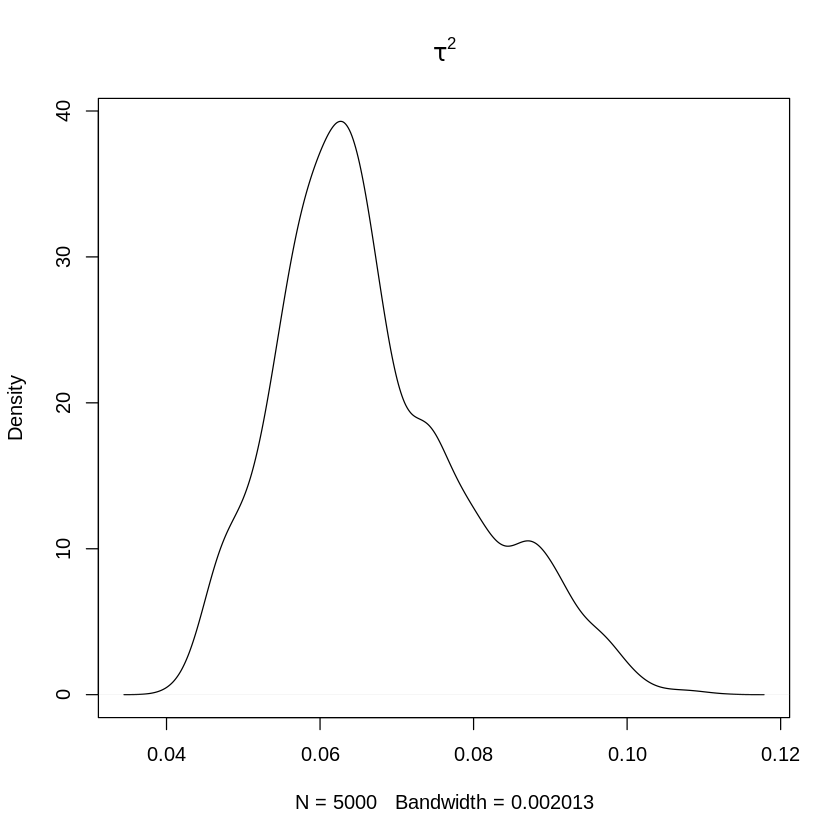

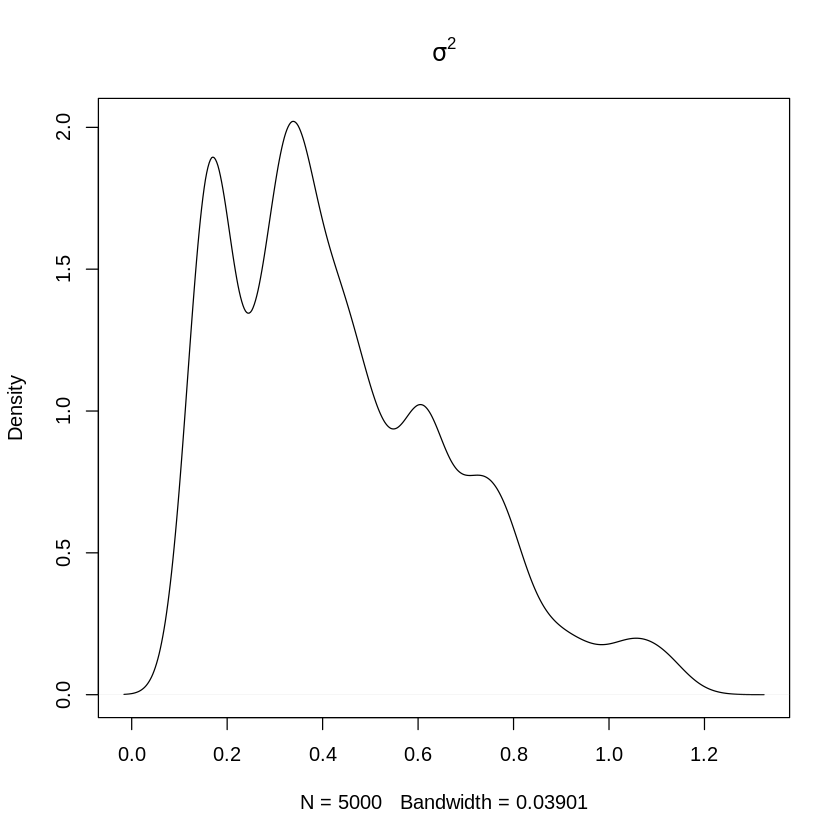

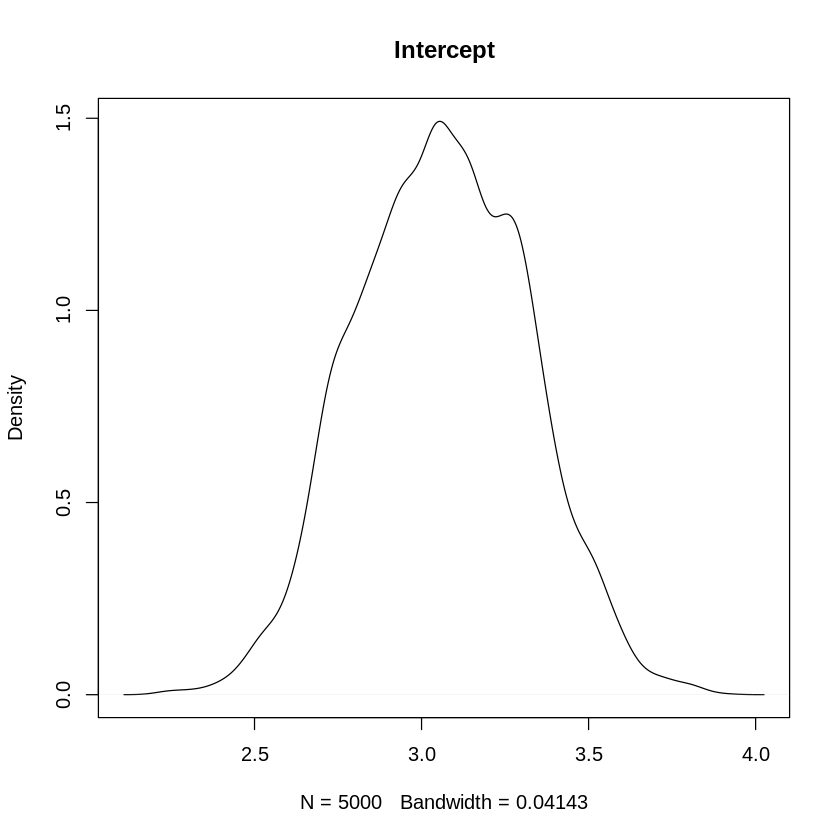

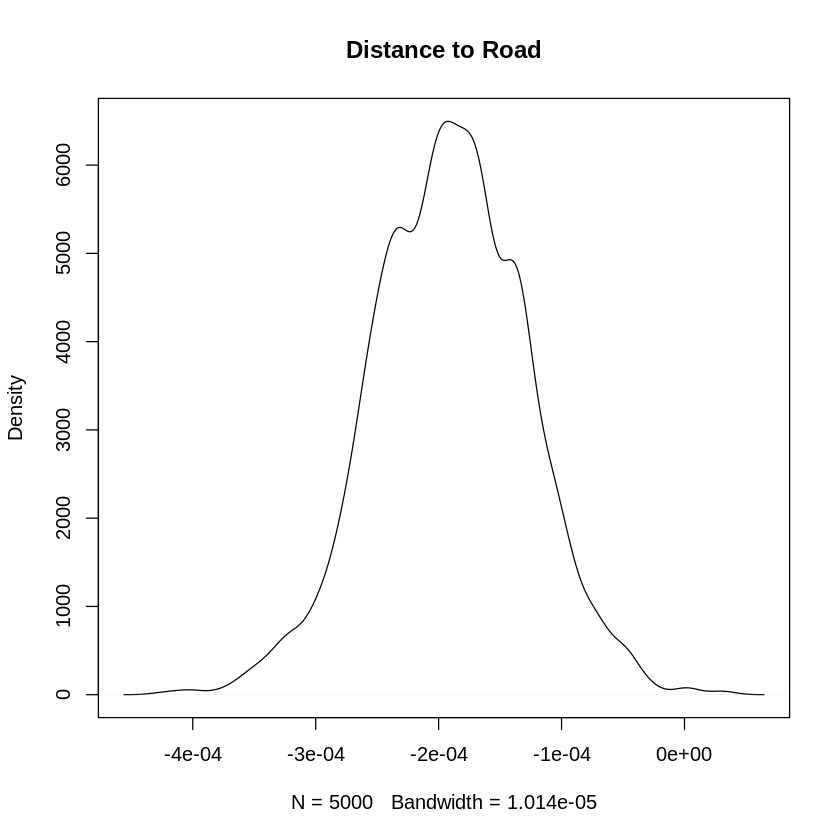

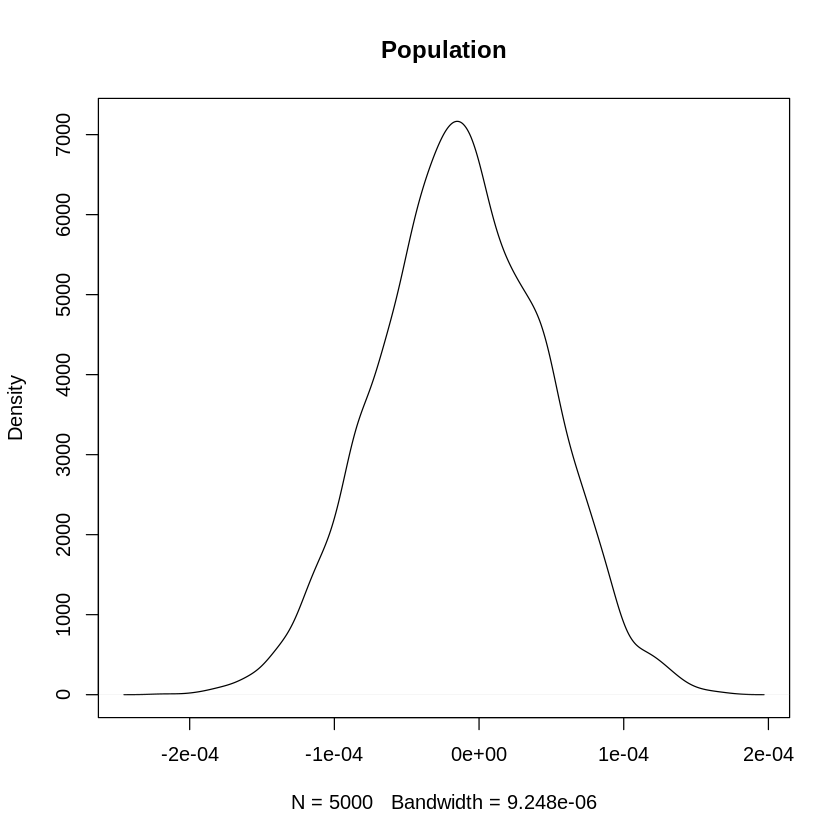

In [253]:
dtau = density(model.presence$samples$tau2)
dsigma = density(model.presence$samples$sigma2)

plot(dtau,main=expression(tau^2))
plot(dsigma,main=expression(sigma^2))
plot(beta1,main="Intercept")
plot(beta2,main="Distance to Road")
plot(beta3,main="Population")

In [202]:
mod_sig = glm(formula, data=TDF, family=binomial())
#mod1.summary()

In [203]:
summary(mod_sig)


Call:
glm(formula = formula, family = binomial(), data = TDF)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4668  -0.4331  -0.4152  -0.3961   2.3224  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.339e+00  1.434e-01 -16.317   <2e-16 ***
Disttoroadm -9.027e-05  5.469e-05  -1.651   0.0988 .  
Populationm  4.470e-05  4.833e-05   0.925   0.3550    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2342.0  on 4060  degrees of freedom
Residual deviance: 2338.4  on 4058  degrees of freedom
AIC: 2344.4

Number of Fisher Scoring iterations: 5


In [204]:
confint(mod_sig)

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-2.624556e+00,-2.062391e+00
Disttoroadm,-1.979250e-04,1.659753e-05
Populationm,-4.997744e-05,1.395857e-04


## Instantiate Geospatial data

In [13]:
library(lattice)
library(sp)


In [14]:
coordinates(TDF) <- c("Longitude","Latitude")

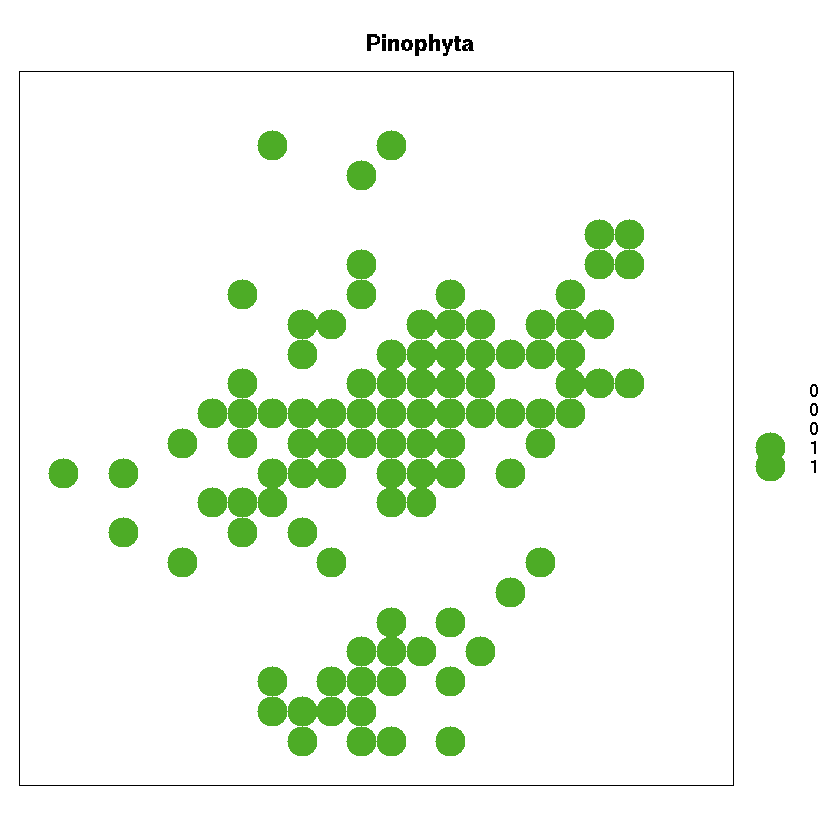

In [15]:
bubble(TDF,"Pinophyta")

## Spatial analysis in R
First, exploratory

In [29]:
library(gstat)

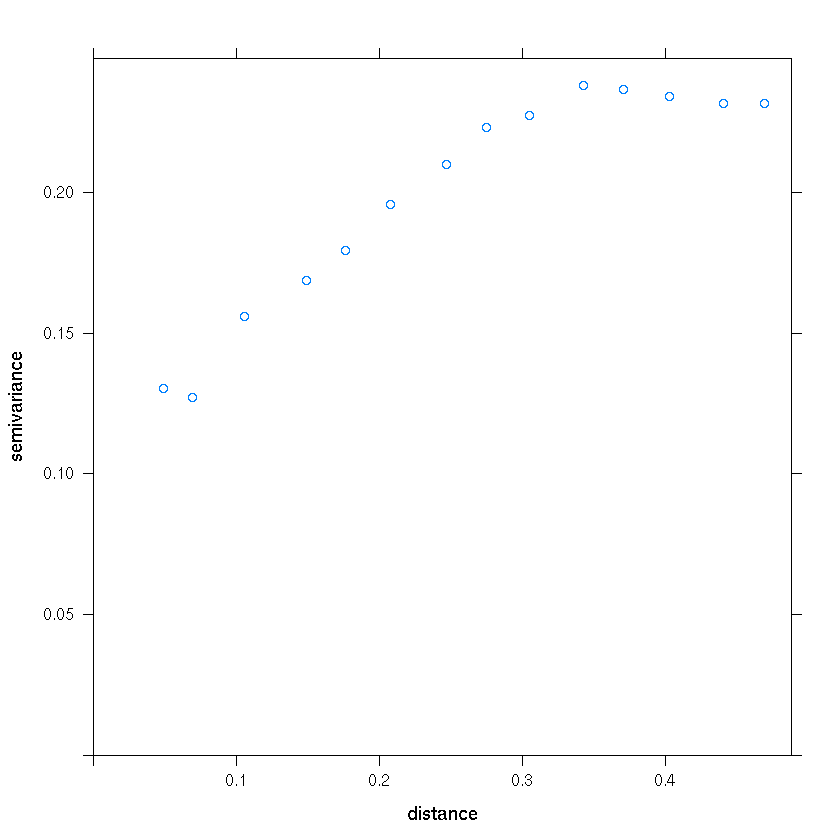

In [39]:
plot(variogram(Pinophyta ~ 1,TDF))

In [40]:
install.packages("geoR")

Warning message in install.packages("geoR"):
“installation of package ‘geoR’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [41]:
install.packages("geoRglm")

also installing the dependency ‘geoR’

Warning message in install.packages("geoRglm"):
“installation of package ‘geoR’ had non-zero exit status”Warning message in install.packages("geoRglm"):
“installation of package ‘geoRglm’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [46]:
library('spdep')

Loading required package: Matrix
Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`


In [47]:
model_car = spautolm(Pinophyta ~ Dist.to.road_m +  Population_m + tipos,data=TDF,family="CAR")

ERROR: Error in inherits(listw, "listw"): argument "listw" is missing, with no default
